In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[-100, 600, -100, 600],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)


Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
# deep_dipole_coordinates = (
#     [ 300,  750, 1200, 300, 1200, 1750],  # µm
#     [ 300, 1000, 1700, 1600, 300, 1000],  # µm
#     [-600, -600, -600, -600, -600, -600],  # µm
# )
# deep_dipole_moments = mg.angles_to_vector(
#     inclination=[-90, 90, -90, 90, 90, -90],
#     declination=[0, 0, 0, 0, 0, 0],
#     amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
# )

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 7
sourcers2 = 7
np.random.seed(2)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 470, sourcers1),np.random.randint(30, 470, sourcers2), [250]]),  # µm
    np.concatenate([np.random.randint(30, 470, sourcers1),np.random.randint(30, 470, sourcers2), [250]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-20]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(np.shape(dipole_moments))
print(np.shape(dipole_coordinates))



(15, 3)
(3, 15)


In [5]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 351, x: 351)
Coordinates:
  * x        (x) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y        (y) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z        (y, x) float64 986kB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 986kB 1.295 1.286 1.276 1.267 ... 12.3 12.18 12.05

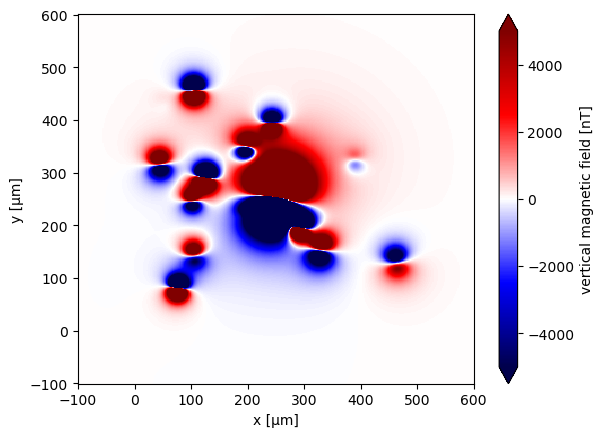

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [7]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

# data.bz.values += 2000

Add a polynomial shift to the data

In [8]:
# a, b, c, d, e, f, g = 1, 2, -1, 3, -2, 1, 0.5
# a, b, c, d, e, f, g = 1.0, 0.5, 0.2, -1.0, 0.8, -2.0, 0.3
# pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
# data['poly'] = (pol/pol.values.max())*2000


a, b, c, d, e, f, g = 3, 5, -1, 3, -5, 10, 0.5
pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
data['poly'] = abs((pol/pol.values.max())-(pol/pol.values).max())*500

data.poly.attrs = {"long_name": "shift field", "units": "nT"}


# data.bz.values += data.poly.values 

# data.poly.plot.pcolormesh(cmap="seismic")#, vmax=10000, vmin=-10000)

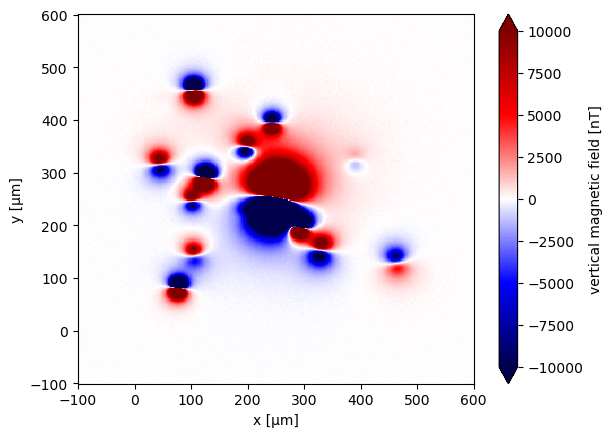

In [9]:
# median = np.median(data.bz.values)
# data.bz.values -= median

data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional Separation

In [10]:
# regional = vd.Trend(degree=1).fit(coordinates, data.bz.values)
# data = data.assign(
#     regional_predicted=regional.predict((data.x, data.y)),
# )
# data.bz.values -= data.regional_predicted.values
# data


data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=1).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset> Size: 4MB
Dimensions:             (y: 351, x: 351)
Coordinates:
  * x                   (x) float64 3kB -100.0 -98.0 -96.0 ... 596.0 598.0 600.0
  * y                   (y) float64 3kB -100.0 -98.0 -96.0 ... 596.0 598.0 600.0
    z                   (y, x) float64 986kB 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 986kB 16.53 -50.71 38.8 ... -32.4 -21.65
    poly                (x, y) float64 986kB 486.1 486.4 486.8 ... 2.217 0.0
    regional_predicted  (y, x) float64 986kB -544.4 -544.0 ... 489.1 489.5

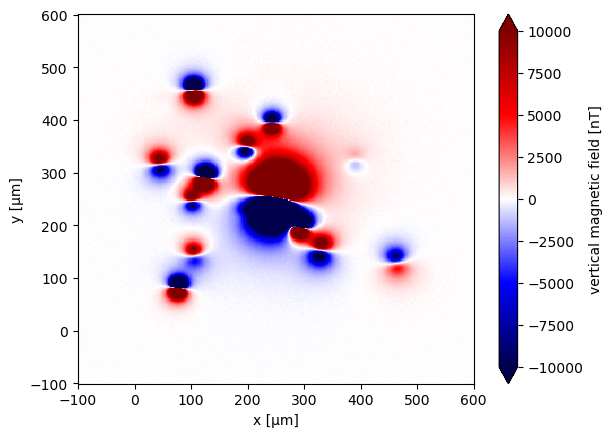

In [11]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [12]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 2MB
Dimensions:  (y: 351, x: 351)
Coordinates:
  * x        (x) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y        (y) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z        (y, x) float64 986kB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 986kB 8.119 8.97 9.577 8.5 ... 4.358 5.318 6.993

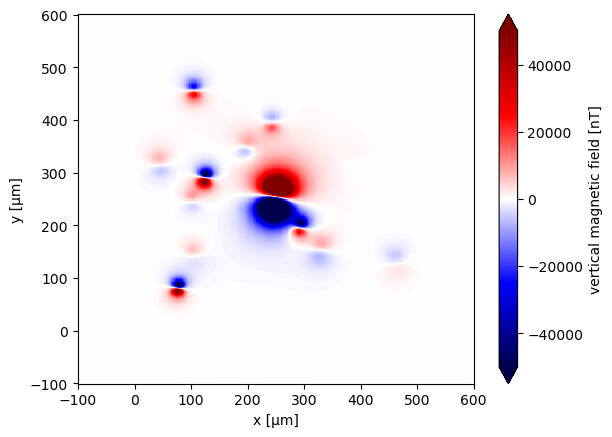

In [13]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [14]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 6MB
Dimensions:  (y: 351, x: 351)
Coordinates:
  * x        (x) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y        (y) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z        (y, x) float64 986kB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 986kB 8.119 8.97 9.577 8.5 ... 4.358 5.318 6.993
    tga      (y, x) float64 986kB 0.5436 0.505 1.164 1.305 ... 1.69 1.264 0.8729
    x_deriv  (y, x) float64 986kB 0.4255 0.3645 -0.1177 ... 0.1309 0.6587 0.8375
    y_deriv  (y, x) float64 986kB -0.276 -0.3295 -0.3389 ... -0.1729 0.03741
    z_deriv  (y, x) float64 986kB -0.1957 -0.1164 -1.107 ... 1.587 1.065 0.2431

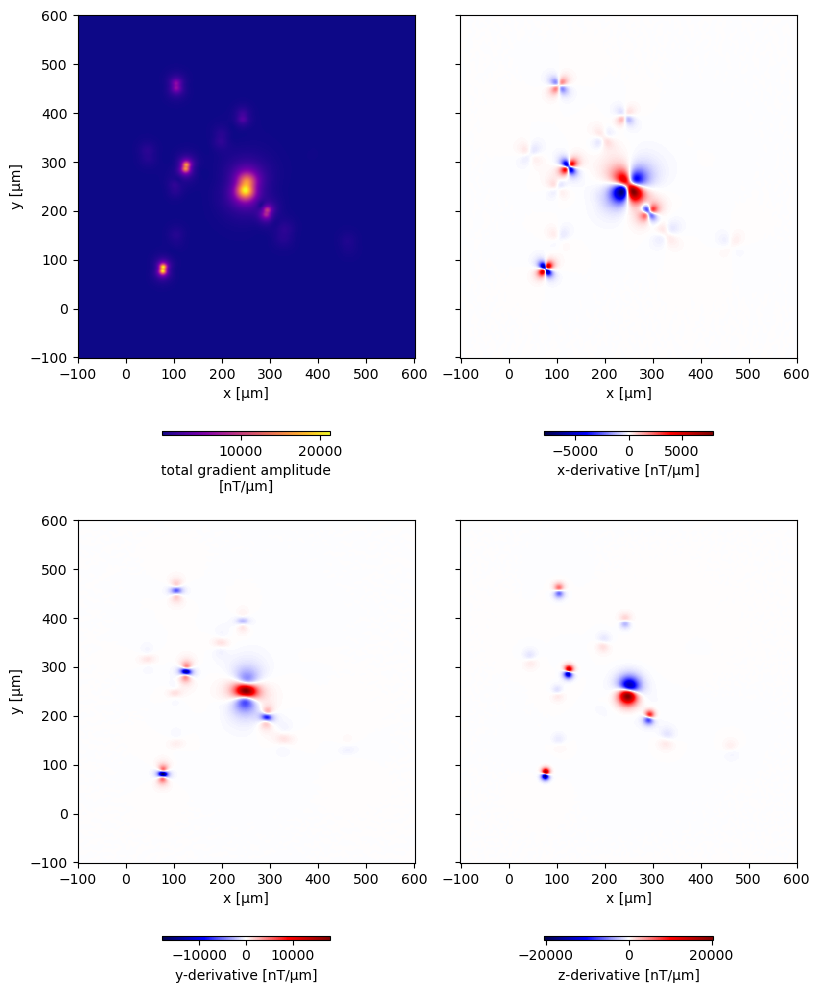

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [16]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

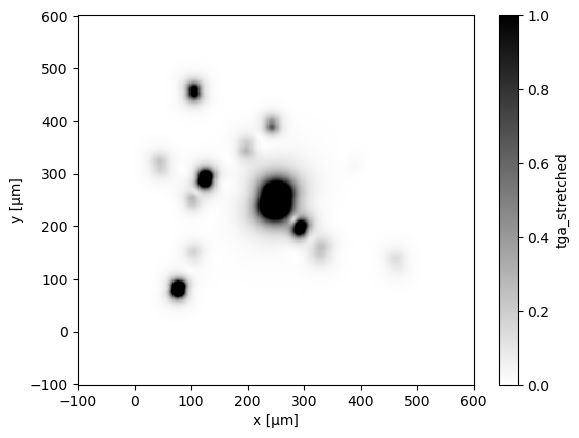

In [17]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [18]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.25,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [19]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

13 potential sources detected within 0.2732 seconds


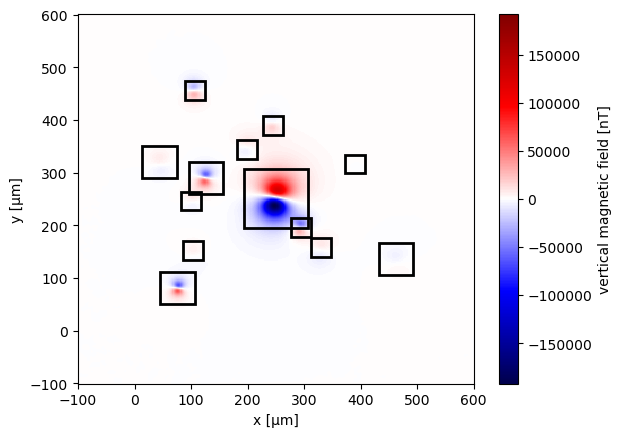

In [20]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [21]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#     bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [22]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

13 euler positions and dipole moments estimated within 0.4652 seconds


Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [23]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.7228222 ,  0.24564336,  0.39840711,  0.30606443, -0.88710983,
       -0.41552243,  1.50750191,  0.54649707, -5.67824659,  0.21289196,
       -0.08598199,  0.32804067,  0.95762753])

In [24]:
# Misfits alculation
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(estimated_dipole_moments, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)

/tmp/ipykernel_8142/3758845858.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


# Iterative Euler deconvolution

In [25]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameters, obs_data, coordinates):
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    # de, dn = de_orig*mg.MICROMETER_TO_METER, dn_orig*mg.MICROMETER_TO_METER
    de, dn, du = parameters[0], parameters[1], parameters[2]
    mx, my, mz = parameters[3], parameters[4], parameters[5]
    
    e, n, u = coordinates[0], coordinates[1], coordinates[2]
    # print(mx)
    # bz = np.zeros(np.shape(obs_data))
    # for i in numba.prange(e.size):
    distance = choclo.utils.distance_cartesian(
            e,
            n,
            u,
            de,
            dn,
            du,
        )

    bz = constant *(mx*choclo.point.kernel_eu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+
        
          my*choclo.point.kernel_nu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+

          mz*choclo.point.kernel_uu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)
                   )
    
    Res = np.linalg.norm( (obs_data)-bz.ravel() )
    return(Res)

In [26]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [27]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')

    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [28]:
minimization

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 60.93525845513559
             x: [ 9.978e-01  9.998e-01  1.021e+00  2.031e-02  1.011e+00
                 -1.976e-01]
           nit: 395
          nfev: 646
 final_simplex: (array([[ 9.978e-01,  9.998e-01, ...,  1.011e+00,
                        -1.976e-01],
                       [ 9.978e-01,  9.998e-01, ...,  1.011e+00,
                        -1.976e-01],
                       ...,
                       [ 9.978e-01,  9.998e-01, ...,  1.011e+00,
                        -1.976e-01],
                       [ 9.978e-01,  9.998e-01, ...,  1.011e+00,
                        -1.976e-01]]), array([ 6.094e+01,  6.094e+01,  6.094e+01,  6.094e+01,
                        6.094e+01,  6.094e+01,  6.094e+01]))

In [29]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 1.9305 seconds


In [30]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

,x,y,z,bz,z_deriv
0,196.0,196.0,10.0,-6139.842534,-146.849401
1,198.0,196.0,10.0,-6700.801340,-150.827737
2,200.0,196.0,10.0,-7306.411031,-153.178937
3,202.0,196.0,10.0,-7957.597207,-153.563436
4,204.0,196.0,10.0,-8652.294621,-153.727960


In [31]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
print(positions_itr[:, 2])

[77.00969087 80.99842754 -2.05778099]


In [32]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

[194.02071315606497, 305.97928684393503, 194.02071315606497, 305.97928684393503]

0

[95.55512469891254, 156.44487530108745, 259.55512469891255, 320.44487530108745]

1

[45.555124698912536, 106.44487530108746, 49.555124698912536, 110.44487530108746]

2

[88.32233047033631, 123.67766952966369, 438.3223304703363, 473.6776695296637]

3

[276.3223304703363, 311.6776695296637, 178.3223304703363, 213.6776695296637]

4

[226.3223304703363, 261.6776695296637, 372.3223304703363, 407.6776695296637]

5

[180.3223304703363, 215.6776695296637, 326.3223304703363, 361.6776695296637]

6

[13.555124698912536, 74.44487530108746, 289.55512469891255, 350.44487530108745]

7

[82.32233047033631, 117.67766952966369, 228.3223304703363, 263.6776695296637]

8

[312.3223304703363, 347.6776695296637, 140.3223304703363, 175.6776695296637]

9

[86.32233047033631, 121.67766952966369, 134.3223304703363, 169.6776695296637]

10

[431.55512469891255, 492.44487530108745, 105.55512469891254, 166.44487530108745]

11

[372.3223304703363, 407.6776695296637, 298.3223304703363, 333.6776695296637]

12

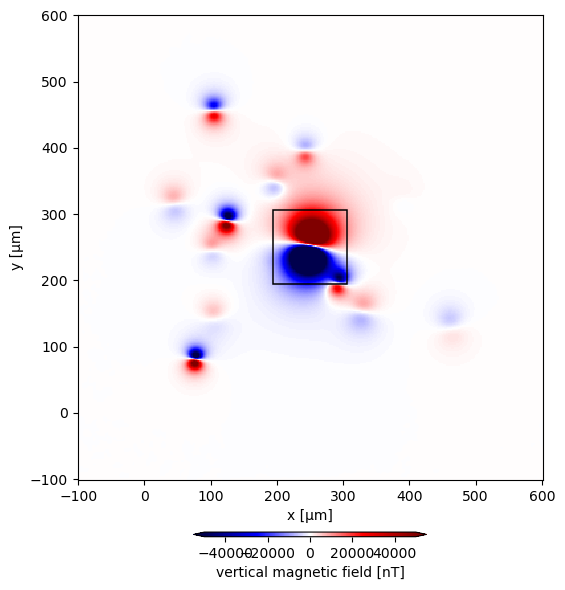

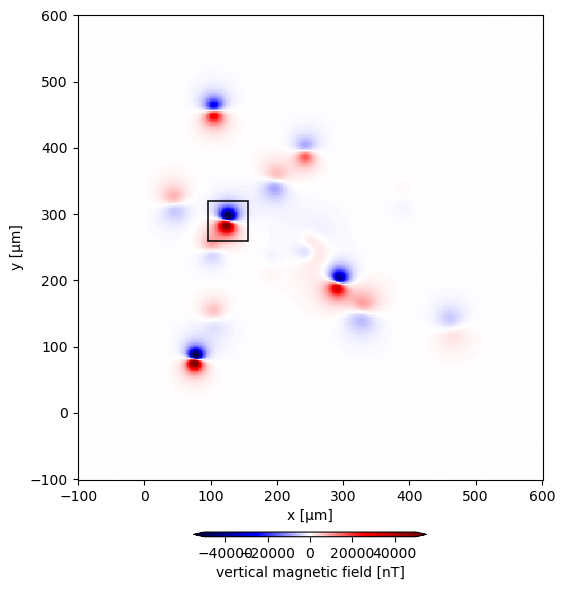

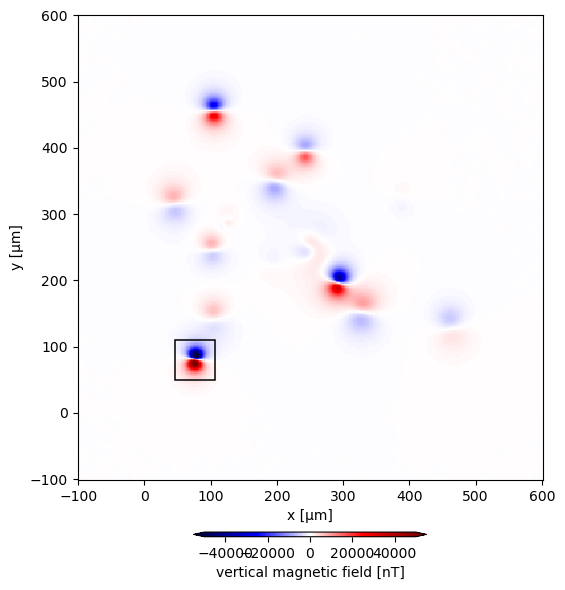

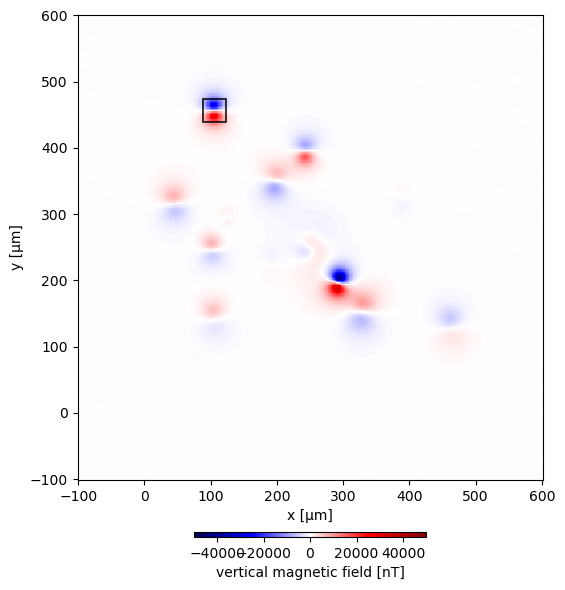

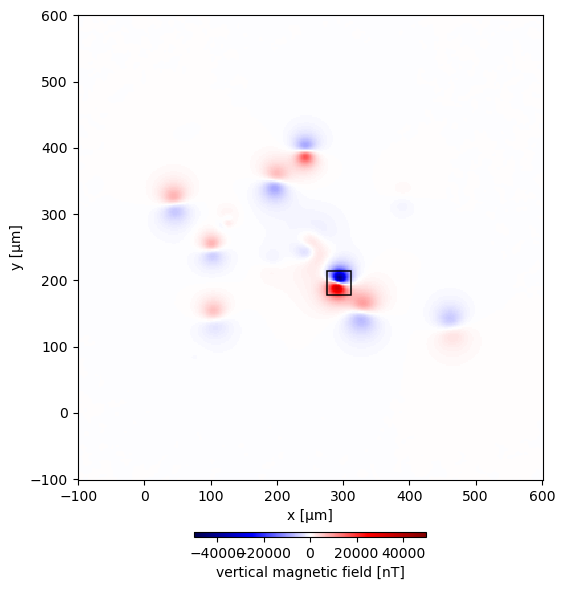

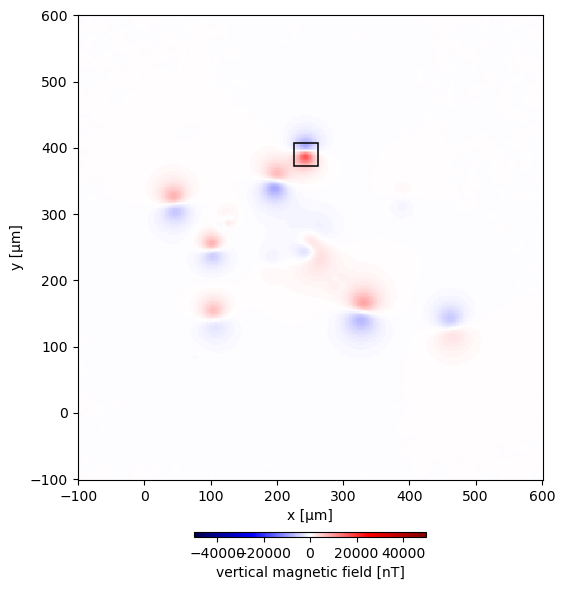

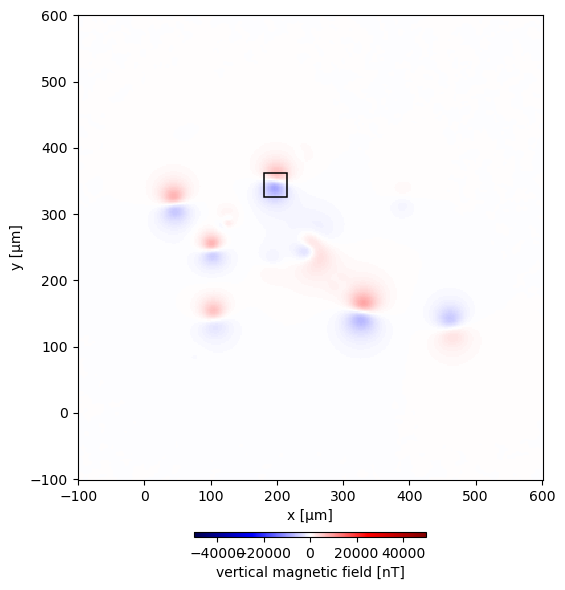

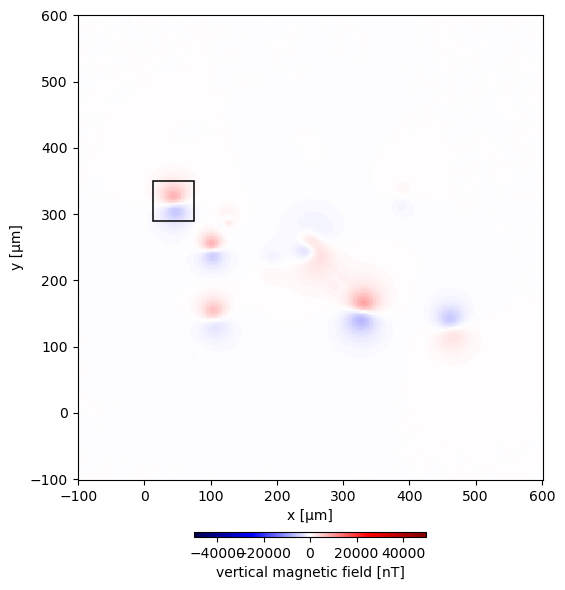

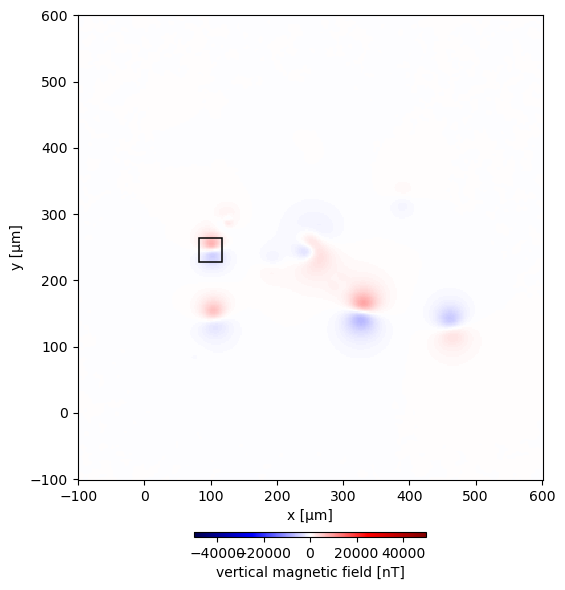

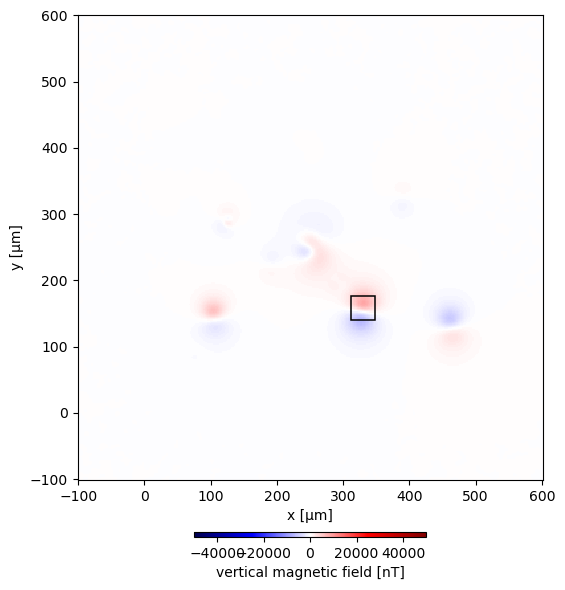

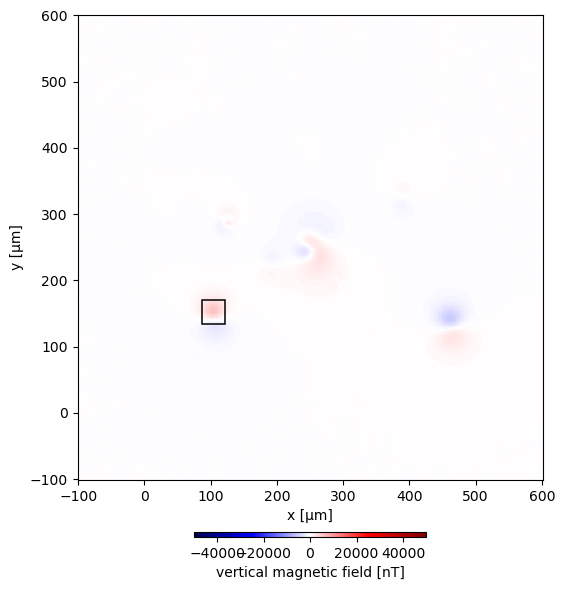

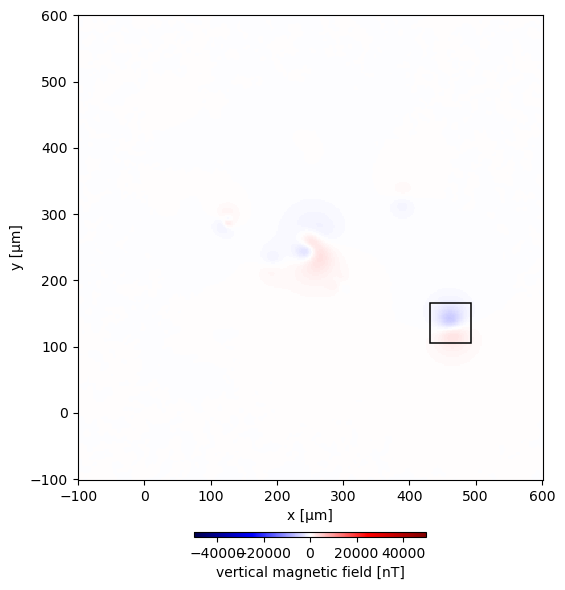

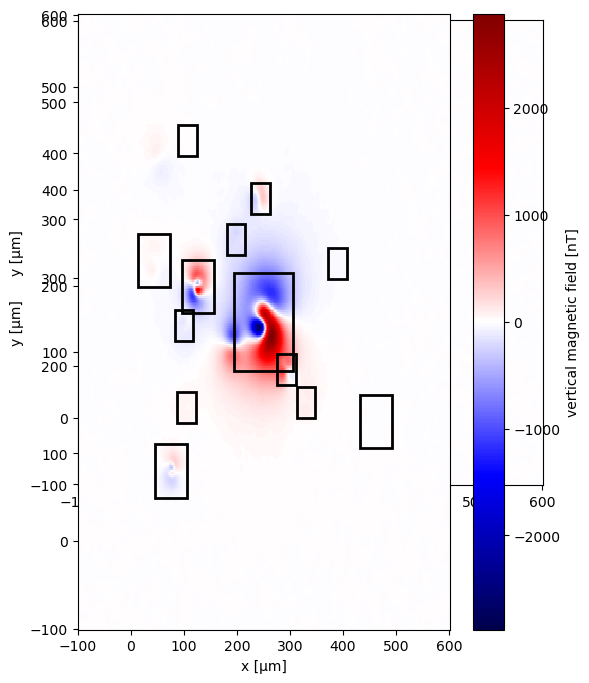

In [63]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=1.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

###################################################

# ax = plt.subplot(111)
# data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
# for window in windows:
#     rect = matplotlib.patches.Rectangle(
#         xy=[window[0], window[2]],
#         width=window[1] - window[0],
#         height=window[3] - window[2],
#         edgecolor="k",
#         fill=False,
#         linewidth=2,
#     )
#     ax.add_patch(rect)   

##################################################

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    print(window)
    print(index)
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    # # store the results with the itr Euler (without interfering sources)
    # print(estimated_dipole_moments_itr_euler[index])
    # print(positions_itr[:, index])
    # estimated_dipole_moments_itr_euler[index] = moment
    # positions_itr[:, index] = position

    # print(moment)
    # print(position)
    # print()
    # #########

    #############

    fig, ax = plt.subplots(1, 1, figsize=(6, 8))#, sharey="row") 
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.085, shrink=0.5)
    
    data_up_copy.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000, cbar_kwargs=cbar_kwargs)

    
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
    ax.set_aspect("equal")
    # plt.tight_layout()
    fig.show()

    #############
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


In [34]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr))[1]
z_difference_itr = positions_itr[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr
# euler_r2_itr_cond


array([ 0.00326675, -0.01335346, -0.05778099, -0.00146341, -0.02304843,
       -0.00573409,  0.07850002,  0.16609818,  0.25745942,  0.11325643,
        0.19618741,  0.02002022,  0.03271369])

# Comparison plots

## Euler comparison

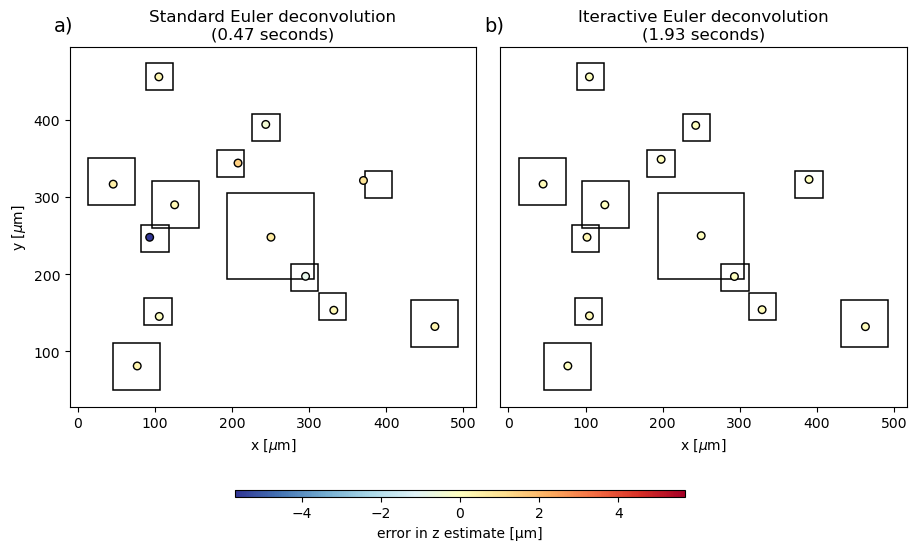

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((z_difference, z_difference_itr))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

## Directions and Dipole Moments comparions

### Iterative Euler (withou interf. sources)

In [36]:
# Misfits alculation
direction_misfit_itr_euler = []
magnetic_moment_misfit_itr_euler = []

for estimated, true in zip(estimated_dipole_moments_itr_euler, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler.append(dir_misfit)
    magnetic_moment_misfit_itr_euler.append(magm_mom_misfit)

In [37]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

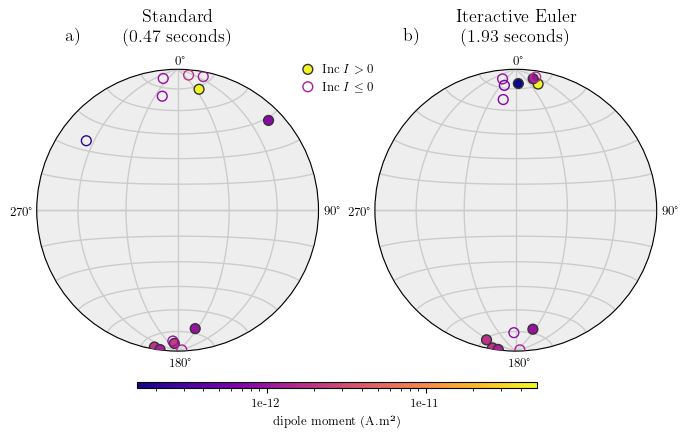

In [38]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

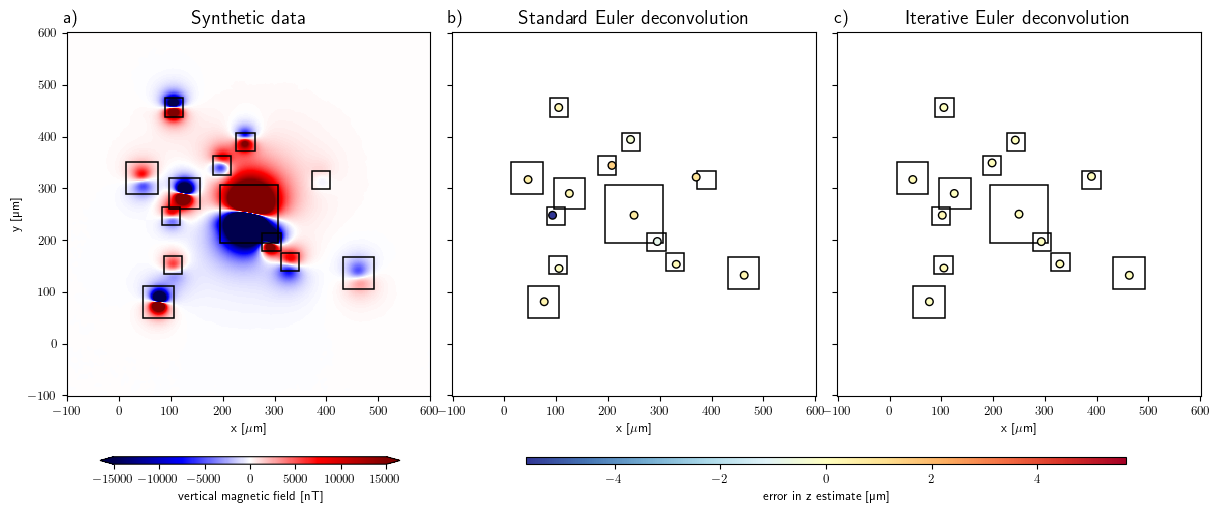

In [39]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference, z_difference_itr))

    ax = axes[1]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


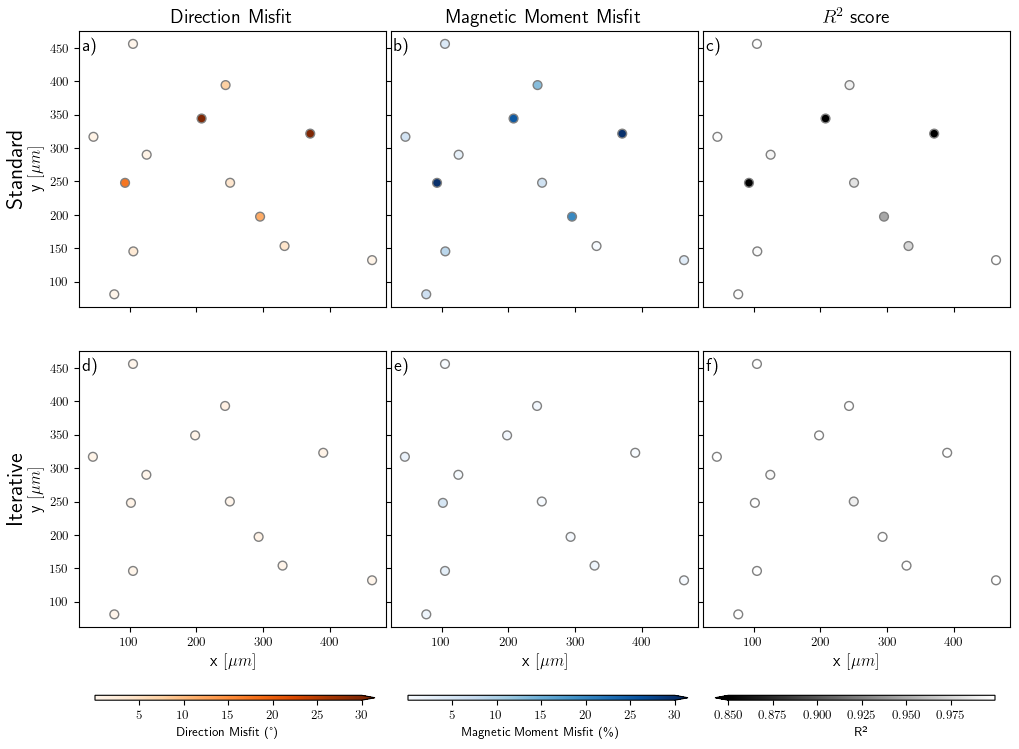

In [40]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_itr_euler, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_itr_euler, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_itr_euler, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    fig.savefig(fig_dir / "inversion-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

In [41]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


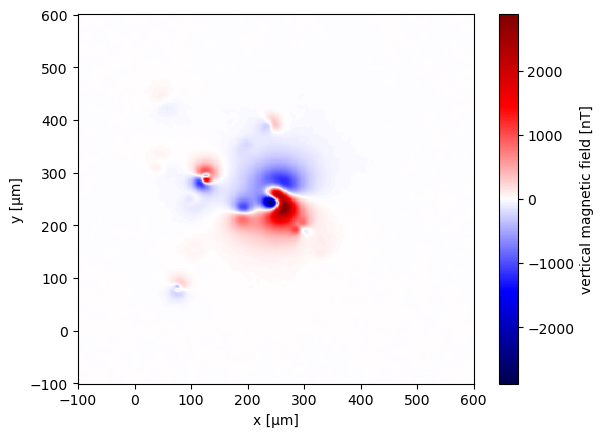

In [64]:
ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    # ax.add_patch(rect)   

In [43]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 6MB
Dimensions:  (y: 351, x: 351)
Coordinates:
  * x        (x) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y        (y) float64 3kB -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z        (y, x) float64 986kB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 986kB 0.9448 2.205 3.095 ... -5.011 -3.735 -1.658
    tga      (y, x) float64 986kB 0.8137 0.7213 1.461 ... 1.688 1.432 1.174
    x_deriv  (y, x) float64 986kB 0.6299 0.5377 -0.0001421 ... 0.8382 1.039
    y_deriv  (y, x) float64 986kB 0.1672 0.1321 0.1365 ... -0.141 0.2573 0.48
    z_deriv  (y, x) float64 986kB -0.4872 -0.4624 -1.455 ... 1.66 1.132 0.2624

In [44]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [45]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.09,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [46]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

13 potential sources detected within 0.278 seconds


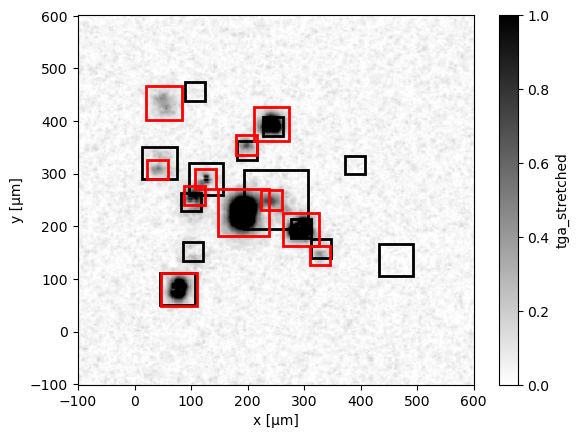

In [47]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [48]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ 20.33732969  83.66267031 402.33732969 465.66267031]


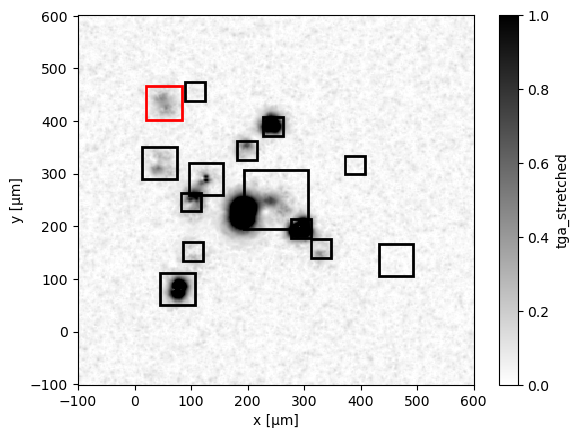

In [49]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [50]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 52.57426006 434.36035408 -18.62912448]

[-9.14118338e-15  2.11332369e-14 -9.98807255e-16]

(2.4838338803558604, -23.39089976112582, 2.304718097233396e-14)

0.9944494925091236

In [51]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr_enhanced))[1]
z_difference_itr_enhanced = positions_itr_enhanced[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr_enhanced

array([ 0.00326675, -0.01335346, -0.05778099, -0.00146341, -0.02304843,
       -0.00573409,  0.07850002,  0.16609818,  0.25745942,  0.11325643,
        0.19618741,  0.02002022,  0.03271369,  0.37087552])

In [52]:
# Misfits alculation
direction_misfit_itr_euler_enhanced = []
magnetic_moment_misfit_itr_euler_enhanced = []

for estimated, true in zip(estimated_dipole_moments_itr_euler_enhanced, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler_enhanced.append(dir_misfit)
    magnetic_moment_misfit_itr_euler_enhanced.append(magm_mom_misfit)

/tmp/ipykernel_8142/2222737513.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


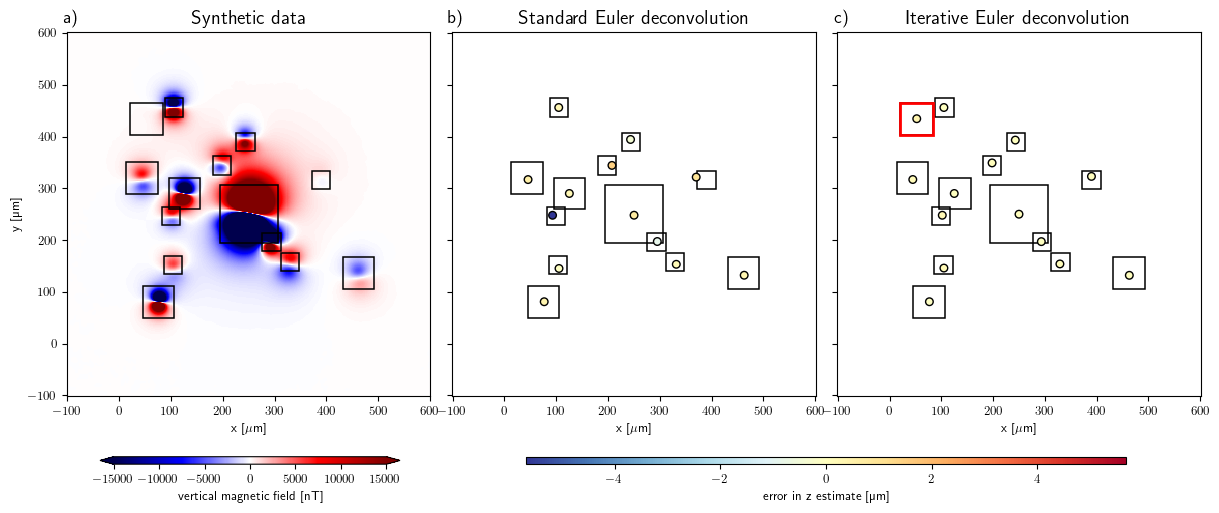

In [53]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference))

    ax = axes[1]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="r",
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr_enhanced[:2], c=z_difference_itr_enhanced, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


/tmp/ipykernel_8142/1437840045.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)


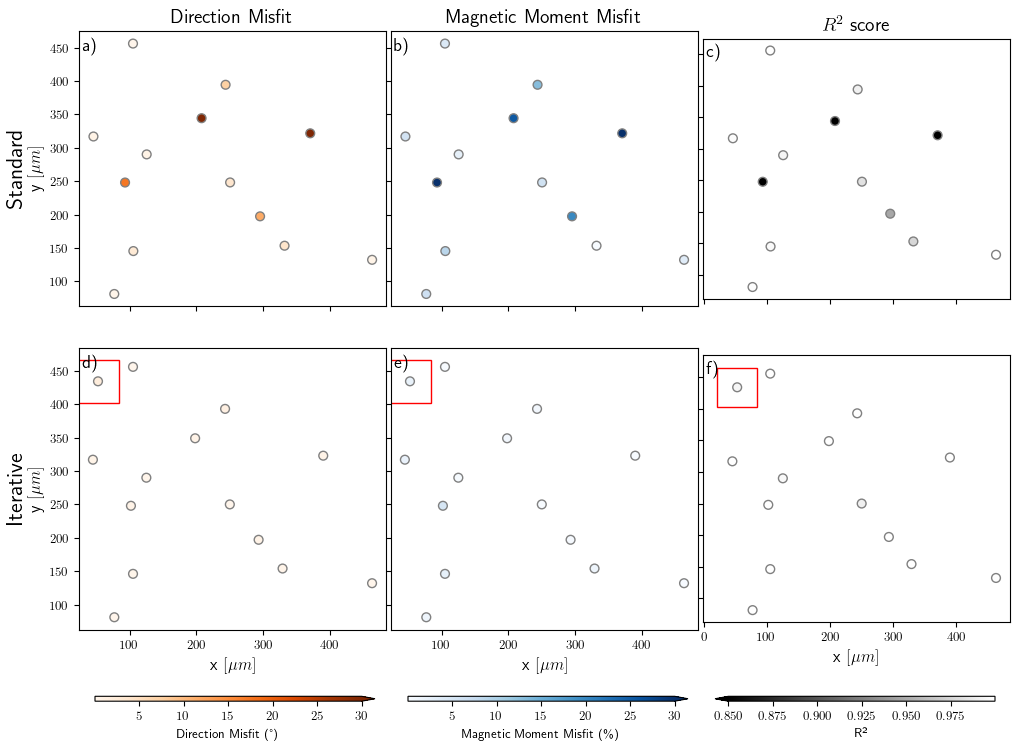

In [54]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=direction_misfit_itr_euler_enhanced, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=magnetic_moment_misfit_itr_euler_enhanced, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=calculated_r2_itr_euler_enhanced, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        if ax == axes[-1] or ax == axes[-2] or ax == axes[-3]:
            for window in non_overlapping_windows:
                rect = matplotlib.patches.Rectangle(
                    xy=[window[0], window[2]],
                    width=window[1] - window[0],
                    height=window[3] - window[2],
                    edgecolor="r",
                    fill=False,
                    linewidth=1,
                )
                ax.add_patch(rect)

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    # fig.savefig(fig_dir / "inversion-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

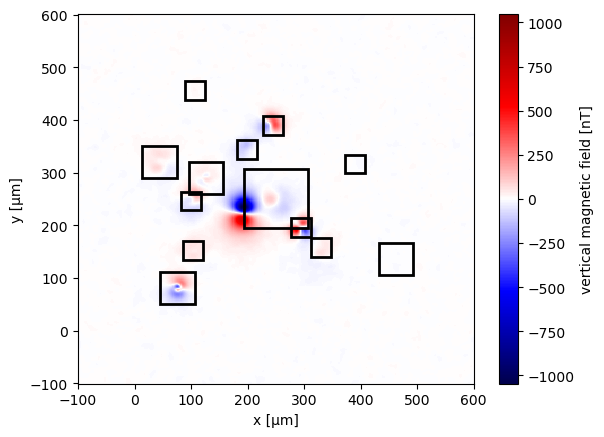

In [55]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   